<a href="https://colab.research.google.com/github/SmyrnaSc/TCC/blob/main/TCC_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [ ]:
dados = spark.read.csv("/content/drive/MyDrive/TCC_BANCOS/online-misogyny-eacl2021-main/data/final_labels.csv",
                       escape = '\"',
                       inferSchema= True,
                       header = True)

In [ ]:
dados.show()

+-------------+--------------------+--------------------+----------+----------------+--------------------+--------------------+---------------+--------------------+--------------------+-----+------------+---------------+--------------------+-----------------+--------------------+--------------------+-----+
|     entry_id|             link_id|           parent_id| entry_utc|       subreddit|              author|                body|          image|          label_date|                week|group| sheet_order|        level_1|             level_2|          level_3|            strength|           highlight|split|
+-------------+--------------------+--------------------+----------+----------------+--------------------+--------------------+---------------+--------------------+--------------------+-----+------------+---------------+--------------------+-----------------+--------------------+--------------------+-----+
|       exoxn7|           t3_exoxn7|                null|1580652620|badwomen

In [ ]:
dados=dados[['body','level_1']]
dados.show()

+--------------------+---------------+
|                body|        level_1|
+--------------------+---------------+
|Do you have the s...|Nonmisogynistic|
|This is taking a ...|           null|
|                   1|           null|
|Honestly my favor...|Nonmisogynistic|
|Source? Doesnt so...|Nonmisogynistic|
|Damn, I saw a mov...|   Misogynistic|
|It's a question o...|           null|
|           (1, 3, 1)|          train|
|Some places have ...|Nonmisogynistic|
|So if I drink eno...|Nonmisogynistic|
|You'll Benjamin B...|Nonmisogynistic|
|Isn't this the pl...|Nonmisogynistic|
|No idea. I watche...|Nonmisogynistic|
|In the movie ther...|Nonmisogynistic|
|One of my friends...|Nonmisogynistic|
|What kinda Tom Br...|Nonmisogynistic|
|  Recommended by F.F|Nonmisogynistic|
|Professionals say...|Nonmisogynistic|
|     Virgina Spread |Nonmisogynistic|
|*I can't believe ...|Nonmisogynistic|
+--------------------+---------------+
only showing top 20 rows



In [ ]:
print(f'N° de Linhas:{dados.count()}', f'N° de colunas:{len(dados.columns)}')

N° de Linhas:15189 N° de colunas:2


In [ ]:
dados.printSchema()

root
 |-- body: string (nullable = true)
 |-- level_1: string (nullable = true)



In [ ]:
print("Negativo")
dados.filter(dados.level_1 == "Nonmisogynistic").select("body", "level_1").limit(5).show(truncate = False)
print("Positivo")
dados.filter(dados.level_1 == "Misogynistic").select("body", "level_1").limit(5).show(truncate = False)

Negativo
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|body                                                                                                                                                                    |level_1        |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|Do you have the skin of a 80 year old grandma? Worry no more, just drink water!                                                                                         |Nonmisogynistic|
|Honestly my favorite thing about this is that they feel the need to cite beauty professionals in order to prove that dehydration is caused by not drinking enough water.|Nonmisogynistic|
|Source? Doesnt sound right to me idk                   

Limpeza dos dados nulos

In [ ]:
dados = dados.dropna(subset="body")
print(f'N° de Linhas:{dados.count()}', f'N° de colunas:{len(dados.columns)}')

N° de Linhas:9005 N° de colunas:2


In [ ]:
dados = dados.dropna(subset="level_1")
print(f'N° de Linhas:{dados.count()}', f'N° de colunas:{len(dados.columns)}')

N° de Linhas:5226 N° de colunas:2


Verificar como limpa uma coluna com dados específicos, para a coluna body quando existir o número '1' e para a coluna level_1 quando existir a palavra 'train'

In [ ]:
dados.limit(10).show()

+--------------------+---------------+
|                body|        level_1|
+--------------------+---------------+
|Do you have the s...|Nonmisogynistic|
|Honestly my favor...|Nonmisogynistic|
|Source? Doesnt so...|Nonmisogynistic|
|Damn, I saw a mov...|   Misogynistic|
|           (1, 3, 1)|          train|
|Some places have ...|Nonmisogynistic|
|So if I drink eno...|Nonmisogynistic|
|You'll Benjamin B...|Nonmisogynistic|
|Isn't this the pl...|Nonmisogynistic|
|No idea. I watche...|Nonmisogynistic|
+--------------------+---------------+



In [ ]:
dados = dados.filter(dados.body != "1").select("body", "level_1")

In [ ]:
dados = dados.filter(dados.level_1 != "train").select("body", "level_1")

In [ ]:
print(f'N° de Linhas:{dados.count()}', f'N° de colunas:{len(dados.columns)}')

N° de Linhas:4783 N° de colunas:2


In [ ]:
dados.filter(dados.level_1 == "Nonmisogynistic").select("body", "level_1").groupBy('level_1').count().show(truncate = False)
dados.filter(dados.level_1 == "Misogynistic").select("body", "level_1").groupBy('level_1').count().show(truncate = False)

+---------------+-----+
|level_1        |count|
+---------------+-----+
|Nonmisogynistic|4246 |
+---------------+-----+

+------------+-----+
|level_1     |count|
+------------+-----+
|Misogynistic|317  |
+------------+-----+



Equilibrando a base de dados

In [ ]:
from pyspark.sql.functions import col, explode, array, lit

In [ ]:
maior_df = dados.filter(col("level_1") == "Nonmisogynistic")
menor_df = dados.filter(col("level_1") == "Misogynistic")
ratio = int(maior_df.count()/menor_df.count())
print("ratio: {}".format(ratio))

ratio: 13


In [ ]:
sampled_majority_df = maior_df.sample(False, 1/ratio)
combined_df_2 = sampled_majority_df.unionAll(menor_df)
combined_df_2.show()

+--------------------+---------------+
|                body|        level_1|
+--------------------+---------------+
|*I can't believe ...|Nonmisogynistic|
|never look on the...|Nonmisogynistic|
|I feel sad for hi...|Nonmisogynistic|
|But remember, the...|Nonmisogynistic|
|Plot twist he act...|Nonmisogynistic|
|Were dew-ritos a ...|Nonmisogynistic|
|The same thing ha...|Nonmisogynistic|
|Unless you are bl...|Nonmisogynistic|
|               LMFAO|Nonmisogynistic|
|Labeling everythi...|Nonmisogynistic|
|                   F|Nonmisogynistic|
|                   U|Nonmisogynistic|
|Not even jews in ...|Nonmisogynistic|
|I know, I was wor...|Nonmisogynistic|
|How can people fo...|Nonmisogynistic|
|        Just did it |Nonmisogynistic|
|Typical garbage f...|Nonmisogynistic|
|Is this for real?...|Nonmisogynistic|
|These people are ...|Nonmisogynistic|
|That's cute. :3 I...|Nonmisogynistic|
+--------------------+---------------+
only showing top 20 rows



In [ ]:
dados = combined_df_2

In [ ]:
dados.filter(dados.level_1 == "Nonmisogynistic").select("body", "level_1").groupBy('level_1').count().show(truncate = False)
dados.filter(dados.level_1 == "Misogynistic").select("body", "level_1").groupBy('level_1').count().show(truncate = False)

+---------------+-----+
|level_1        |count|
+---------------+-----+
|Nonmisogynistic|371  |
+---------------+-----+

+------------+-----+
|level_1     |count|
+------------+-----+
|Misogynistic|317  |
+------------+-----+



Criação de uma coluna índice (index)

In [ ]:
from pyspark.sql import SparkSession, functions as F
from pyspark import SparkConf
conf = SparkConf()

spark = SparkSession.builder.config(conf=conf).appName('Dataframe with Indexes').getOrCreate()


df = dados

rdd_df = df.rdd.zipWithIndex()
df_final = rdd_df.toDF()

df_final = df_final.withColumn('body', df_final['_1'].getItem("body"))
df_final = df_final.withColumn('level_1', df_final['_1'].getItem("level_1"))

In [ ]:
df_final = df_final.withColumnRenamed("_2","index")

In [ ]:
dados=df_final[['index','body','level_1']]
dados.show()

+-----+--------------------+---------------+
|index|                body|        level_1|
+-----+--------------------+---------------+
|    0|*I can't believe ...|Nonmisogynistic|
|    1|never look on the...|Nonmisogynistic|
|    2|I feel sad for hi...|Nonmisogynistic|
|    3|But remember, the...|Nonmisogynistic|
|    4|Plot twist he act...|Nonmisogynistic|
|    5|Were dew-ritos a ...|Nonmisogynistic|
|    6|The same thing ha...|Nonmisogynistic|
|    7|Unless you are bl...|Nonmisogynistic|
|    8|               LMFAO|Nonmisogynistic|
|    9|Labeling everythi...|Nonmisogynistic|
|   10|                   F|Nonmisogynistic|
|   11|                   U|Nonmisogynistic|
|   12|Not even jews in ...|Nonmisogynistic|
|   13|I know, I was wor...|Nonmisogynistic|
|   14|How can people fo...|Nonmisogynistic|
|   15|        Just did it |Nonmisogynistic|
|   16|Typical garbage f...|Nonmisogynistic|
|   17|Is this for real?...|Nonmisogynistic|
|   18|These people are ...|Nonmisogynistic|
|   19|Tha

Criação da nuvem de palavras

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
amostra = dados.select('body').sample(fraction = 0.1, seed = 0)
tudo = [texto['body'] for texto in amostra.collect()]

In [ ]:
wordcloud = WordCloud(background_color = 'white',
                      width = 1000,
                      height = 600,
                      collocations = False, 
                      prefer_horizontal = 1).generate(str(tudo))

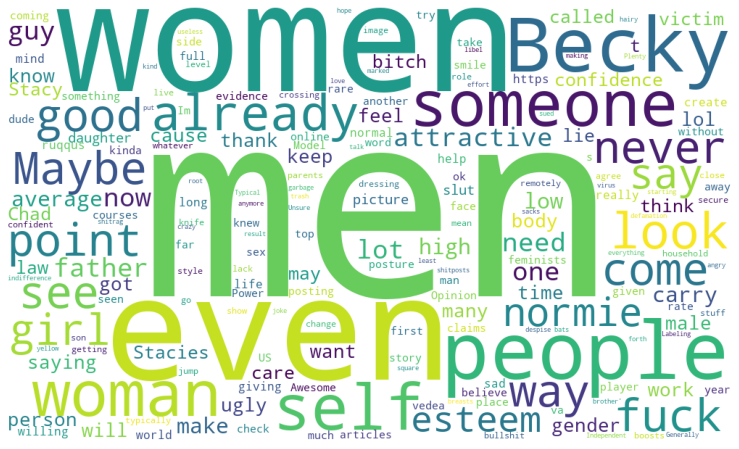

In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Limpeza dos caracteres especiais

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
import pyspark.sql.functions as f

In [ ]:
dados = dados.withColumn("texto_regex", f.regexp_replace("body", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [ ]:
dados.limit(5).show(truncate=False)

+-----+------------------------------------------------------------------------------------------------------------------------------+---------------+--------------------------------------------------------------------------------------------------------------------------+
|index|body                                                                                                                          |level_1        |texto_regex                                                                                                               |
+-----+------------------------------------------------------------------------------------------------------------------------------+---------------+--------------------------------------------------------------------------------------------------------------------------+
|0    |*I can't believe it's not* virgina spread open                                                                                |Nonmisogynistic|I cant believe its not virgi

In [ ]:
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex) )

In [ ]:
dados.limit(2).show()

+-----+--------------------+---------------+--------------------+--------------------+
|index|                body|        level_1|         texto_regex|         texto_limpo|
+-----+--------------------+---------------+--------------------+--------------------+
|    0|*I can't believe ...|Nonmisogynistic|I cant believe it...|I cant believe it...|
|    1|never look on the...|Nonmisogynistic|never look on the...|never look on the...|
+-----+--------------------+---------------+--------------------+--------------------+



Tokenização do texto

In [ ]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [ ]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|I cant believe it...|[i, cant, believe...|
|never look on the...|[never, look, on,...|
|I feel sad for hi...|[i, feel, sad, fo...|
|But remember thei...|[but, remember, t...|
|Plot twist he act...|[plot, twist, he,...|
|Were dewritos a t...|[were, dewritos, ...|
|The same thing ha...|[the, same, thing...|
|Unless you are bl...|[unless, you, are...|
|               LMFAO|             [lmfao]|
|Labeling everythi...|[labeling, everyt...|
|                   F|                 [f]|
|                   U|                 [u]|
|Not even jews in ...|[not, even, jews,...|
|I know I was worr...|[i, know, i, was,...|
|How can people fo...|[how, can, people...|
|         Just did it|     [just, did, it]|
|Typical garbage f...|[typical, garbage...|
|Is this for real ...|[is, this, for, r...|
|These people are ...|[these, people, a...|
|Thats cute 3 I tr...|[thats, cu

Contagem dos tokens

In [ ]:
from pyspark.sql.types import IntegerType

In [ ]:
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens").withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|I cant believe it...|[i, cant, believe...|          8|
|never look on the...|[never, look, on,...|          8|
|I feel sad for hi...|[i, feel, sad, fo...|         28|
|But remember thei...|[but, remember, t...|          7|
|Plot twist he act...|[plot, twist, he,...|         19|
|Were dewritos a t...|[were, dewritos, ...|         18|
|The same thing ha...|[the, same, thing...|         34|
|Unless you are bl...|[unless, you, are...|         22|
|               LMFAO|             [lmfao]|          1|
|Labeling everythi...|[labeling, everyt...|         18|
|                   F|                 [f]|          1|
|                   U|                 [u]|          1|
|Not even jews in ...|[not, even, jews,...|         12|
|I know I was worr...|[i, know, i, was,...|         31|
|How can people fo...|[how, can, people...|     

Retirada das stop words

In [ ]:
#teste (nltk)
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_nltk = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from pyspark.ml.feature import StopWordsRemover

stop = StopWordsRemover.loadDefaultStopWords("english")

In [ ]:
from pyspark.ml.feature import Tokenizer

In [ ]:
tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens" )
tokenized = tokenizer.transform(dados)


In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final", stopWords= stop)
feature_data = remover.transform(tokenizado)

In [ ]:
feature_data.select("tokens", "texto_final").limit(11).show(truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                                                                                                     |texto_final                                                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens").withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|I cant believe it...|[i, cant, believe...|          8|
|never look on the...|[never, look, on,...|          8|
|I feel sad for hi...|[i, feel, sad, fo...|         28|
|But remember thei...|[but, remember, t...|          7|
|Plot twist he act...|[plot, twist, he,...|         19|
|Were dewritos a t...|[were, dewritos, ...|         18|
|The same thing ha...|[the, same, thing...|         34|
|Unless you are bl...|[unless, you, are...|         22|
|               LMFAO|             [lmfao]|          1|
|Labeling everythi...|[labeling, everyt...|         18|
|                   F|                 [f]|          1|
|                   U|                 [u]|          1|
|Not even jews in ...|[not, even, jews,...|         12|
|I know I was worr...|[i, know, i, was,...|         31|
|How can people fo...|[how, can, people...|     

In [ ]:
feature_data.select("tokens", "texto_final")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
          .withColumn("Freq_tokens_limpos",  countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[i, cant, believe...|[cant, believe, v...|          8|                 5|
|[never, look, on,...|[never, look, bri...|          8|                 5|
|[i, feel, sad, fo...|[feel, sad, hes, ...|         28|                13|
|[but, remember, t...|[remember, posts,...|          7|                 4|
|[plot, twist, he,...|[plot, twist, act...|         19|                 9|
|[were, dewritos, ...|[dewritos, thing,...|         18|                 9|
|[the, same, thing...|[thing, happened,...|         34|                19|
|[unless, you, are...|[unless, black, d...|         22|                12|
|             [lmfao]|             [lmfao]|          1|                 1|
|[labeling, everyt...|[labeling, everyt...|         18|                10|
|                 [f]|   

In [ ]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final','CountVec').limit(5).show()#truncate=False

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[cant, believe, v...|(3047,[23,101,400...|
|[never, look, bri...|(3047,[13,38,50,2...|
|[feel, sad, hes, ...|(3047,[4,31,48,50...|
|[remember, posts,...|(3047,[110,308,79...|
|[plot, twist, act...|(3047,[77,214,712...|
+--------------------+--------------------+



In [ ]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(1000)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)




In [ ]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[cant, believe, v...|(1000,[26,194,275...|
|[never, look, bri...|(1000,[32,281,477...|
|[feel, sad, hes, ...|(1000,[0,93,115,2...|
|[remember, posts,...|(1000,[116,685,69...|
|[plot, twist, act...|(1000,[40,86,106,...|
+--------------------+--------------------+



In [ ]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)


In [ ]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate = False)

+---------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|texto_final                                                                      |features                                                                                                                                                                                                                                                                                                    |
+---------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
TFIDFfeaturizedData.groupBy('level_1').count().show()

+---------------+-----+
|        level_1|count|
+---------------+-----+
|Nonmisogynistic|  371|
|   Misogynistic|  317|
+---------------+-----+



In [ ]:
from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="level_1", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)

In [ ]:
dados.groupBy(['level_1','label']).count().show()

+---------------+-----+-----+
|        level_1|label|count|
+---------------+-----+-----+
|Nonmisogynistic|  0.0|  371|
|   Misogynistic|  1.0|  317|
+---------------+-----+-----+



Definição dos dados de treino(train) e teste(test)

In [ ]:
train, test = dados.randomSplit([0.7, 0.3], seed = 1)

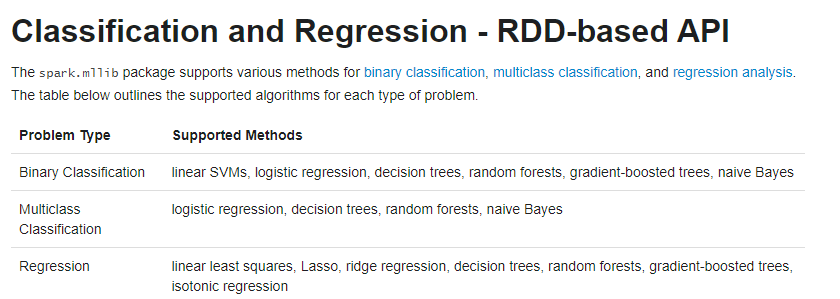

https://spark.apache.org/docs/2.2.0/mllib-classification-regression.html

Árvore de Decisão

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline_arvore = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf, dt])

In [ ]:
dados_transformados = pipeline_arvore.fit(dados).transform(dados)
dados_transformados.limit(5).show()

+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|index|                body|        level_1|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|    0|*I can't believe ...|Nonmisogynistic|I cant believe it...|I cant believe it...|  0.0|[i, cant, believe...|[cant, believe, v...|(1000,[26,194,275...|(1000,[26,194,275...| [313.0,95.0]|[0.76715686274509...|       0.0|
|    1|never look on the...|Nonmisogynistic|never look on the...|never look on the...|  0.0|[never, look, on

In [ ]:
dt_model_treino = pipeline_arvore.fit(train)
predictions_treino_arvore = dt_model_treino.transform(train)

In [ ]:
dt_model_teste = pipeline_arvore.fit(test)
predictions_teste_arvore = dt_model_teste.transform(test)

In [ ]:
predictions_teste_arvore.show()

+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|index|                body|        level_1|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|    4|Plot twist he act...|Nonmisogynistic|Plot twist he act...|Plot twist he act...|  0.0|[plot, twist, he,...|[plot, twist, act...|(1000,[40,86,106,...|(1000,[40,86,106,...| [106.0,16.0]|[0.86885245901639...|       0.0|
|    5|Were dew-ritos a ...|Nonmisogynistic|Were dewritos a t...|Were dewritos a t...|  0.0|[were, dewritos,

In [ ]:
predictions_teste_arvore.select(['label','prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

In [ ]:
print("Acuracia = %f" % evaluator.evaluate(predictions_teste_arvore, {evaluator.metricName:'accuracy'}))
print("Precisão = %f" % evaluator.evaluate(predictions_teste_arvore, {evaluator.metricName:'precisionByLabel'}))
print("Recall = %f" % evaluator.evaluate(predictions_teste_arvore, {evaluator.metricName:'recallByLabel'}))
print("F1 = %f" % evaluator.evaluate(predictions_teste_arvore, {evaluator.metricName:'fMeasureByLabel'}))

Acuracia = 0.920561
Precisão = 0.876923
Recall = 0.991304
F1 = 0.930612


Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
rfr = RandomForestRegressor(featuresCol='features', labelCol='label', maxDepth=10, numTrees=10)

pipeline_randomforest = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf, rfr])



In [ ]:
rfr_model_treino = pipeline_randomforest.fit(train)
predictions_treino_ranomforest = rfr_model_treino.transform(train)

In [ ]:
rfr_model_teste = pipeline_randomforest.fit(test)
predictions_teste_randomforest = rfr_model_teste.transform(test)

In [ ]:
predictions_teste_randomforest.show()

+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------------+
|index|                body|        level_1|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|         prediction|
+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------------+
|    4|Plot twist he act...|Nonmisogynistic|Plot twist he act...|Plot twist he act...|  0.0|[plot, twist, he,...|[plot, twist, act...|(1000,[40,86,106,...|(1000,[40,86,106,...|0.20655298223774832|
|    5|Were dew-ritos a ...|Nonmisogynistic|Were dewritos a t...|Were dewritos a t...|  0.0|[were, dewritos, ...|[dewritos, thing,...|(1000,[430,645,84...|(1000,[430,645,84...|0.19369019179937003|
|   13|I know, 

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

In [ ]:
print("Acuracia = %f" % evaluator.evaluate(predictions_teste_randomforest, {evaluator.metricName:'accuracy'}))
print("Precisão = %f" % evaluator.evaluate(predictions_teste_randomforest, {evaluator.metricName:'precisionByLabel'}))
print("Recall = %f" % evaluator.evaluate(predictions_teste_randomforest, {evaluator.metricName:'recallByLabel'}))
print("F1 = %f" % evaluator.evaluate(predictions_teste_randomforest, {evaluator.metricName:'fMeasureByLabel'}))

Acuracia = 0.126168
Precisão = 0.000000
Recall = 0.000000
F1 = 0.000000


Regressão Logistica

In [ ]:
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.001)

pipeline_logisticregression = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf, lr])



In [ ]:
lr_model_treino = pipeline_logisticregression.fit(train)
predictions_treino_logisticregression = lr_model_treino.transform(train)

In [ ]:
lr_model_teste = pipeline_logisticregression.fit(test)
predictions_teste_logisticregression = lr_model_teste.transform(test)

In [ ]:
predictions_teste_logisticregression.show()

+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|index|                body|        level_1|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    4|Plot twist he act...|Nonmisogynistic|Plot twist he act...|Plot twist he act...|  0.0|[plot, twist, he,...|[plot, twist, act...|(1000,[40,86,106,...|(1000,[40,86,106,...|[6.54919268712271...|[0.99857077499254...|       0.0|
|    5|Were dew-ritos a ...|Nonmisogynistic|Were dewritos a t...|Were dewritos a

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

In [ ]:
print("Acuracia = %f" % evaluator.evaluate(predictions_teste_logisticregression, {evaluator.metricName:'accuracy'}))
print("Precisão = %f" % evaluator.evaluate(predictions_teste_logisticregression, {evaluator.metricName:'precisionByLabel'}))
print("Recall = %f" % evaluator.evaluate(predictions_teste_logisticregression, {evaluator.metricName:'recallByLabel'}))
print("F1 = %f" % evaluator.evaluate(predictions_teste_logisticregression, {evaluator.metricName:'fMeasureByLabel'}))

Acuracia = 1.000000
Precisão = 1.000000
Recall = 1.000000
F1 = 1.000000


Naive Bayes


In [ ]:
from pyspark.ml.classification import NaiveBayes

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
nb = NaiveBayes(featuresCol='features', labelCol='label', smoothing=1.0, modelType="multinomial")

pipeline_naive = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf,nb])

In [ ]:
naive_model_treino = pipeline_naive.fit(train)
predictions_treino_naive = naive_model_treino.transform(train)

In [ ]:
naive_model_teste = pipeline_naive.fit(test)
predictions_teste_naive = naive_model_teste.transform(test)

In [ ]:
predictions_teste_naive.show()

+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|index|                body|        level_1|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+---------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    4|Plot twist he act...|Nonmisogynistic|Plot twist he act...|Plot twist he act...|  0.0|[plot, twist, he,...|[plot, twist, act...|(1000,[40,86,106,...|(1000,[40,86,106,...|[-238.43901785507...|[1.0,1.0424079162...|       0.0|
|    5|Were dew-ritos a ...|Nonmisogynistic|Were dewritos a t...|Were dewritos a

In [ ]:
print("Acuracia = %f" % evaluator.evaluate(predictions_teste_naive, {evaluator.metricName:'accuracy'}))
print("Precisão = %f" % evaluator.evaluate(predictions_teste_naive, {evaluator.metricName:'precisionByLabel'}))
print("Recall = %f" % evaluator.evaluate(predictions_teste_naive, {evaluator.metricName:'recallByLabel'}))
print("F1 = %f" % evaluator.evaluate(predictions_teste_naive, {evaluator.metricName:'fMeasureByLabel'}))

Acuracia = 0.985981
Precisão = 0.991228
Recall = 0.982609
F1 = 0.986900


Continuação utilizando Scikit-learn

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/TCC_BANCOS/online-misogyny-eacl2021-main/data/final_labels.csv")

In [ ]:
dataset=dataset[['body','level_1']]
dataset.head()

,body,level_1
0,Do you have the skin of a 80 year old grandma?...,Nonmisogynistic
1,This is taking a grain of truth and extrapolat...,Nonmisogynistic
2,Honestly my favorite thing about this is that ...,Nonmisogynistic
3,Source? Doesnt sound right to me idk,Nonmisogynistic
4,"Damn, I saw a movie in which the old woman bat...",Misogynistic


In [ ]:
dataset.isnull().sum()

body       12
level_1     0
dtype: int64

In [ ]:
dataset.dropna(inplace=True)

In [ ]:
dataset.isnull().sum()

body       0
level_1    0
dtype: int64

In [ ]:
dataset.dtypes

body       object
level_1    object
dtype: object

In [ ]:
df_mask=dataset['level_1']=='Nonmisogynistic'
maior_filtered_df = dataset[df_mask]
maior_df = maior_filtered_df.shape[0]

In [ ]:
maior_filtered_df.groupby('level_1')['level_1'].count()

level_1
Nonmisogynistic    5856
Name: level_1, dtype: int64

In [ ]:
maior_df

5856

In [ ]:
df_mask=dataset['level_1']=='Misogynistic'
menor_filtered_df = dataset[df_mask]
menor_df = menor_filtered_df.shape[0]

In [ ]:
menor_filtered_df.groupby('level_1')['level_1'].count()

level_1
Misogynistic    699
Name: level_1, dtype: int64

In [ ]:
menor_df

699

In [ ]:
from pyspark.sql.functions import col, explode, array, lit

ratio = int(maior_df/menor_df)
print("ratio: {}".format(ratio))

ratio: 8


In [ ]:
sampled_majority_df = maior_filtered_df.sample(frac = 1/ratio)
combined_df_2 = pd.concat([sampled_majority_df, menor_filtered_df])
dataset = combined_df_2
dataset.head()

,body,level_1
1371,"Like, i don't even understand what the logic i...",Nonmisogynistic
2213,And fuck lie detectors...,Nonmisogynistic
4643,I sent 2 mens rights vids to my mom and she sa...,Nonmisogynistic
3994,That's why they keep saying it's all about per...,Nonmisogynistic
5396,The Chad's forearms are as big or bigger than ...,Nonmisogynistic


In [ ]:
dataset.dtypes

body       object
level_1    object
dtype: object

In [ ]:
a_trocar = {
    'Nonmisogynistic': 0,
    'Misogynistic': 1
}
dataset.level_1 = dataset.level_1.map(a_trocar)
dataset.head()

,body,level_1
1371,"Like, i don't even understand what the logic i...",0
2213,And fuck lie detectors...,0
4643,I sent 2 mens rights vids to my mom and she sa...,0
3994,That's why they keep saying it's all about per...,0
5396,The Chad's forearms are as big or bigger than ...,0


In [ ]:
dataset.groupby('level_1')['level_1'].count()

level_1
0    732
1    699
Name: level_1, dtype: int64

In [ ]:
class TColumns(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):

    dataset = X.copy()
    dataset['body'] = dataset['body'].str.replace('[,.:;!?]+', ' ', regex=True).copy()
    dataset['body'] = dataset['body'].str.replace('[/<>()|\+\-\$%&#@\'\"]+', ' ', regex=True).copy()
    dataset['body'] = dataset['body'].str.replace('[0-9]+', '', regex=True)

    return dataset.body

KNN (K-nearest neighbours)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
tco = TColumns()
 
cvt = CountVectorizer(strip_accents='ascii', lowercase=True, stop_words=stop)
 
tfi = TfidfTransformer(use_idf=True)
 
knn = KNeighborsClassifier(n_neighbors=3)
 
knn_pipeline = Pipeline(steps=[('Transformer', tco),
                              ('CountVectorizer', cvt),
                              ('TfidfTransformer', tfi),
                              ('Model', knn)])

In [ ]:
entrada = dataset[['body']]
saida = dataset['level_1']
X_train, X_test, y_train, y_test = train_test_split(entrada, 
                                                    saida, 
                                                    stratify=saida,
                                                    test_size=0.3,
                                                    random_state=1)
knn_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('Transformer', TColumns()),
                ('CountVectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'her', 'hers',
                                             'herself', 'it', 'its', 'itself',
                                             'they', 'them', 'their', 'theirs',
                                             'themselves', 'what', ...],
                                 strip_accents='ascii')),
                ('TfidfTransformer', TfidfTransformer()),
                ('Model', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()

X_train, y_train = rus.fit_resample(X_train, y_train)


In [ ]:
predictions_teste_knn = knn_pipeline.predict(X_test)

In [ ]:
print("Acurácia: {}".format(metrics.accuracy_score(y_test, predictions_teste_knn)))
print("Precision: {}".format(metrics.precision_score(y_test, predictions_teste_knn)))
print("Recall: {}".format(metrics.recall_score(y_test, predictions_teste_knn)))
print("F1: {}".format(metrics.f1_score(y_test, predictions_teste_knn)))

Acurácia: 0.6511627906976745
Precision: 0.6829268292682927
Recall: 0.5333333333333333
F1: 0.5989304812834225


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

SVM (Support Vector Machine)




In [ ]:
from sklearn import svm

In [ ]:
tco = TColumns()
 
cvt = CountVectorizer(strip_accents='ascii', lowercase=True, stop_words=stop)
 
tfi = TfidfTransformer(use_idf=True)
 
svm = svm.SVC()
 
svm_pipeline = Pipeline(steps=[('Transformer', tco),
                              ('CountVectorizer', cvt),
                              ('TfidfTransformer', tfi),
                              ('Model', svm)])

In [ ]:
entrada = dataset[['body']]
saida = dataset['level_1']
X_train, X_test, y_train, y_test = train_test_split(entrada, 
                                                    saida, 
                                                    stratify=saida,
                                                    test_size=0.3,
                                                    random_state=1)
svm_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('Transformer', TColumns()),
                ('CountVectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'her', 'hers',
                                             'herself', 'it', 'its', 'itself',
                                             'they', 'them', 'their', 'theirs',
                                             'themselves', 'what', ...],
                                 strip_accents='ascii')),
                ('TfidfTransformer', TfidfTransformer()), ('Model', SVC())])

In [ ]:
predictions_teste_svm = knn_pipeline.predict(X_test)

In [ ]:
print("Acurácia: {}".format(metrics.accuracy_score(y_test, predictions_teste_svm)))
print("Precision: {}".format(metrics.precision_score(y_test, predictions_teste_svm)))
print("Recall: {}".format(metrics.recall_score(y_test, predictions_teste_svm)))
print("F1: {}".format(metrics.f1_score(y_test, predictions_teste_svm)))

Acurácia: 0.6511627906976745
Precision: 0.6829268292682927
Recall: 0.5333333333333333
F1: 0.5989304812834225


BERT (unweighted)

BERT (weighted)

Tabela de resultado de cada modelo

In [ ]:


print("====================================")
print("Árvore de Decisão")
print("====================================")
print("Acuracia = %f" % evaluator.evaluate(predictions_teste_arvore, {evaluator.metricName:'accuracy'}))
print("Precisão = %f" % evaluator.evaluate(predictions_teste_arvore, {evaluator.metricName:'precisionByLabel'}))
print("Recall = %f" % evaluator.evaluate(predictions_teste_arvore, {evaluator.metricName:'recallByLabel'}))
print("F1 = %f" % evaluator.evaluate(predictions_teste_arvore, {evaluator.metricName:'fMeasureByLabel'}))

print("====================================")
print("Random Forest")
print("====================================")
print("Acuracia = %f" % evaluator.evaluate(predictions_teste_randomforest, {evaluator.metricName:'accuracy'}))
print("Precisão = %f" % evaluator.evaluate(predictions_teste_randomforest, {evaluator.metricName:'precisionByLabel'}))
print("Recall = %f" % evaluator.evaluate(predictions_teste_randomforest, {evaluator.metricName:'recallByLabel'}))
print("F1 = %f" % evaluator.evaluate(predictions_teste_randomforest, {evaluator.metricName:'fMeasureByLabel'}))

print("====================================")
print("Regressão Logistica")
print("====================================")
print("Acuracia = %f" % evaluator.evaluate(predictions_teste_logisticregression, {evaluator.metricName:'accuracy'}))
print("Precisão = %f" % evaluator.evaluate(predictions_teste_logisticregression, {evaluator.metricName:'precisionByLabel'}))
print("Recall = %f" % evaluator.evaluate(predictions_teste_logisticregression, {evaluator.metricName:'recallByLabel'}))
print("F1 = %f" % evaluator.evaluate(predictions_teste_logisticregression, {evaluator.metricName:'fMeasureByLabel'}))

print("====================================")
print("Naive Bayes")
print("====================================")
print("Acuracia = %f" % evaluator.evaluate(predictions_teste_naive, {evaluator.metricName:'accuracy'}))
print("Precisão = %f" % evaluator.evaluate(predictions_teste_naive, {evaluator.metricName:'precisionByLabel'}))
print("Recall = %f" % evaluator.evaluate(predictions_teste_naive, {evaluator.metricName:'recallByLabel'}))
print("F1 = %f" % evaluator.evaluate(predictions_teste_naive, {evaluator.metricName:'fMeasureByLabel'}))


print("====================================")
print("KNN")
print("====================================")
print("Acurácia: {}".format(metrics.accuracy_score(y_test, predictions_teste_knn)))
print("Precision: {}".format(metrics.precision_score(y_test, predictions_teste_knn)))
print("Recall: {}".format(metrics.recall_score(y_test, predictions_teste_knn)))
print("F1: {}".format(metrics.f1_score(y_test, predictions_teste_knn)))


print("====================================")
print("SVM")
print("====================================")
print("Acurácia: {}".format(metrics.accuracy_score(y_test, predictions_teste_svm)))
print("Precision: {}".format(metrics.precision_score(y_test, predictions_teste_svm)))
print("Recall: {}".format(metrics.recall_score(y_test, predictions_teste_svm)))
print("F1: {}".format(metrics.f1_score(y_test, predictions_teste_svm)))
print("====================================")

Árvore de Decisão
Acuracia = 0.920561
Precisão = 0.876923
Recall = 0.991304
F1 = 0.930612
Random Forest
Acuracia = 0.126168
Precisão = 0.000000
Recall = 0.000000
F1 = 0.000000
Regressão Logistica
Acuracia = 1.000000
Precisão = 1.000000
Recall = 1.000000
F1 = 1.000000
Naive Bayes
Acuracia = 0.985981
Precisão = 0.991228
Recall = 0.982609
F1 = 0.986900
KNN
Acurácia: 0.6511627906976745
Precision: 0.6829268292682927
Recall: 0.5333333333333333
F1: 0.5989304812834225
SVM
Acurácia: 0.6511627906976745
Precision: 0.6829268292682927
Recall: 0.5333333333333333
F1: 0.5989304812834225


In [ ]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = predictions_teste_knn

confusion_matrix(y_true, y_pred)


array([[168,  52],
       [ 98, 112]])

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = predictions_teste_svm

confusion_matrix(y_true, y_pred)


array([[168,  52],
       [ 98, 112]])